# Classification / Clustering with PyRiemann and ICU waves Data

In [1]:
import sys
print sys.prefix
print sys.version

In [2]:
import pyodbc
import pandas as pd
import numpy as np
import scipy, sklearn
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import pyriemann
from time import gmtime, strftime
%matplotlib inline
pd.options.mode.chained_assignment = None # to avoid pandas warnings
print "np.__version__ :", np.__version__
print "scipy.__version__ :", scipy.__version__
print "pd.__version__:", pd.__version__
print "sklearn.__version__:", sklearn.__version__

np.__version__ : 1.11.1
scipy.__version__ : 0.18.1
pd.__version__: 0.18.1
sklearn.__version__: 0.18


In [3]:
# Load Matrix and target
X = np.load("icu_matrix2.pyriemann.npy")
y = np.load("icu_target2.pyriemann.npy")
X.shape, np.size(y)

((2876L, 5L, 96L), 2876)

In [4]:
print(len(np.nonzero(y)[0]))
print(float(len(np.nonzero(y)[0])) / float(len(y))* 100.)

631
21.9401947149


In [5]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

original_X = X
for case in range(X.shape[0]):
    X[case] = MinMaxScaler().fit_transform(X[case])
#     X[case] = scale(X[case])

In [86]:
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM, FgMDM
from sklearn.cross_validation import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# estimate covariances matrices
cov = pyriemann.estimation.Covariances().fit_transform(X)
cov.shape

(2876L, 5L, 5L)

In [87]:
#
# Cov regularization
#
Id = np.eye(cov.shape[1])
alpha = 1e-01
alpha = 1  # no regularization
for case in range(cov.shape[0]):
#     if case == 0:
#         print(cov[case])
    cov[case] += alpha*Id
#     if case == 0:
#         print(cov[case])

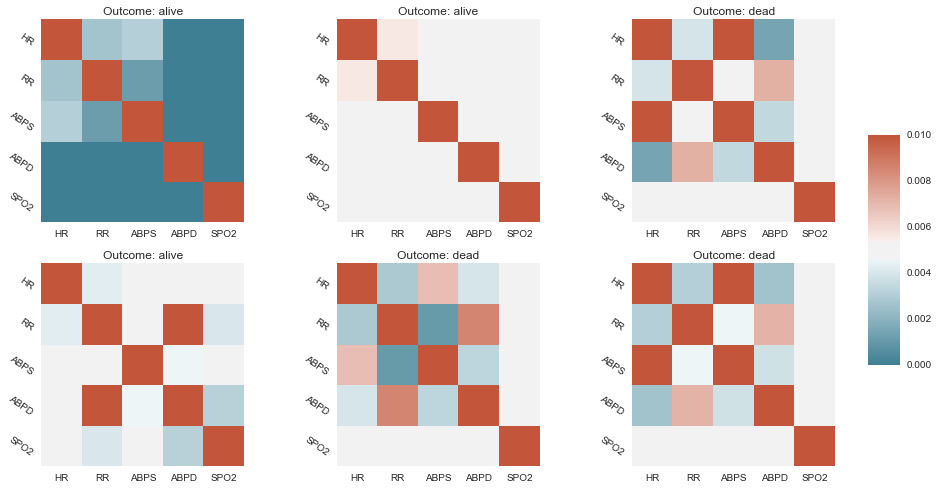

In [75]:
import random
import pandas as pd
f, axarr = plt.subplots(2, 3, figsize=(15, 8))
cbar_ax = f.add_axes([.91, .3, .03, .4])
axarr_f = axarr.flat
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

for i in xrange(6):
    idx = random.randint(0, cov.shape[0])
    if y[idx]:
        title = 'Outcome: dead'
    else:
        title = 'Outcome: alive'
    df = pd.DataFrame(cov[idx])
    df.columns = ['HR', 'RR', 'ABPS', 'ABPD', 'SPO2']
    df.index = ['HR', 'RR', 'ABPS', 'ABPD', 'SPO2']
    axarr_f[i].set_title(title)
    cg = sns.heatmap(df, vmax=.01, square=True, ax=axarr_f[i],
               cbar=i == 0, cbar_ax=None if i else cbar_ax, cmap=cmap)
    plt.setp(axarr_f[i].yaxis.get_majorticklabels(), rotation=-35)

In [81]:
# separate train/test/validation
# Our dataset is unbalanced (death issue is about 20%)
# try StratifiedKFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(y, n_folds=3, random_state=42, shuffle=True)

for i, (train_test_indices, valid_indices) in enumerate(skf):
    if i == 0:
        break

print(len(train_test_indices), len(valid_indices))
X_train_test = cov[train_test_indices]
y_train_test = y[train_test_indices]

X_valid = cov[valid_indices]
y_valid = y[valid_indices]

(1916, 960)


In [82]:
# Our dataset is unbalanced (death outcome is about 20%)
# try StratifiedKFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score

def cross_val_4_clf(clf, X_train_test, y_train_test, n_folds=5):
    cv = StratifiedKFold(y_train_test, n_folds=n_folds)
    accuracy = np.array([], dtype=float)
    for i, (train, test) in enumerate(cv):
        y_pred = clf.fit(X_train_test[train], y_train_test[train]).predict(X_train_test[test])
        acc = accuracy_score(y_train_test[test], y_pred)
        accuracy = np.append(accuracy, [acc])
    print(accuracy.mean())
    plt.plot(range(i+1), accuracy)

In [83]:
# Fit the classifier with the entire train set
# then predict and compute accuracy for the 
# validation set
from sklearn.metrics import roc_curve, auc, roc_auc_score

def valid_4_clf(clf, X_train_test, y_train_test, X_valid, y_valid):
    clf.fit(X_train_test, y_train_test)
    y_valid_pred = clf.predict(X_valid)
    print(accuracy_score(y_valid, y_valid_pred))
    print(roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1]))

0.72024586597
0.707291666667
0.636336600459


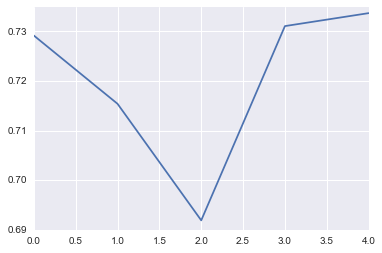

In [95]:
# MDM classifier
mdm = pyriemann.classification.MDM(metric='wasserstein', n_jobs=-1)
cross_val_4_clf(mdm, X_train_test, y_train_test, n_folds=5)
valid_4_clf(mdm, X_train_test, y_train_test, X_valid, y_valid)

0.760967417319
0.769791666667


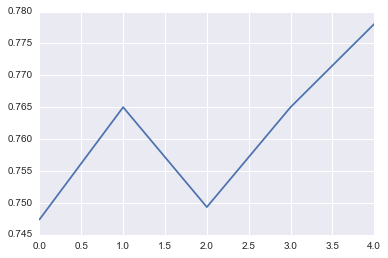

In [13]:
# KNN classifier
knn = pyriemann.classification.KNearestNeighbor(metric='riemann', n_jobs=-1)
cross_val_4_clf(knn, X_train_test, y_train_test)
valid_4_clf(knn, X_train_test, y_train_test, X_valid, y_valid)

0.78079308094
0.780208333333


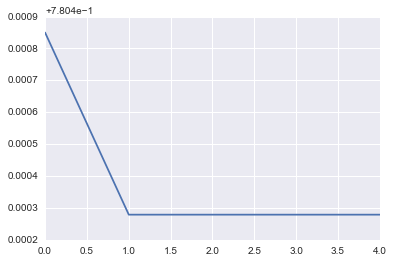

In [14]:
# logistic regression in the tangent space
# from sklearn.linear_model import LogisticRegression
# euclidian_clf = 
ts_lr = pyriemann.classification.TSclassifier(metric='riemann')
cross_val_4_clf(ts_lr, X_train_test, y_train_test)
valid_4_clf(ts_lr, X_train_test, y_train_test, X_valid, y_valid)

In [19]:
# input classifiers has to be fitted
clfs = [mdm, knn, ts_lr]
labels = ['MDM riemann', 'KNN riemann', 'Tangent space + logistic regression']
def roc_auc(clfs, X_valid, y_valid, labels):
    colors = ['#40bf80', '#668cff', '#ffa64d', '#ff33bb', '#330033', '#4dffc3', '#805500', '#999900']
    plt.figure(figsize=(10, 7))
    for i, clf in enumerate(clfs):
        y_proba = clf.predict_proba(X_valid)[:, 1]
        fpr, tpr, _ = roc_curve(y_valid, y_proba)
        ras = roc_auc_score(y_valid, y_proba)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=labels[i]+" (AUC={0:.2f})".format(ras), color=colors[i % len(colors)])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')

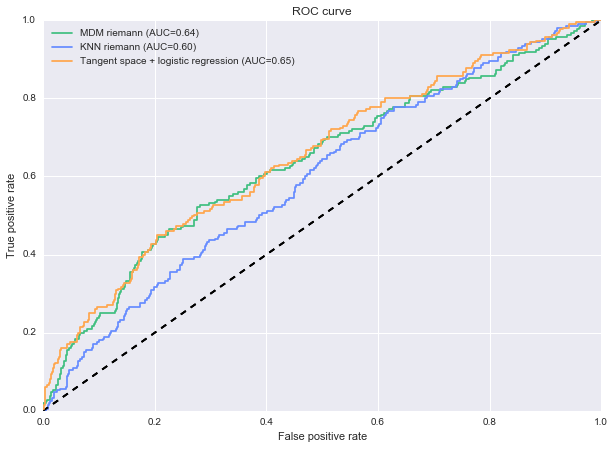

In [20]:
roc_auc(clfs, X_valid, y_valid, labels)

0.794364664926
0.790625


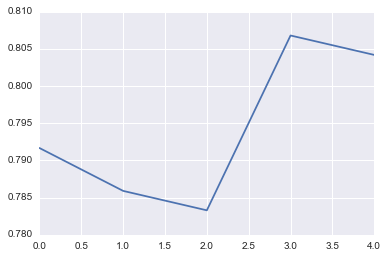

In [45]:
# SVM in the tangent space
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

lsvc = CalibratedClassifierCV(LinearSVC(penalty='l1', dual=False, C=0.78))
ts_lr = pyriemann.classification.TSclassifier(metric='riemann', clf=lsvc)
cross_val_4_clf(ts_lr, X_train_test, y_train_test)
valid_4_clf(ts_lr, X_train_test, y_train_test, X_valid, y_valid)

0.79489229765
0.794791666667


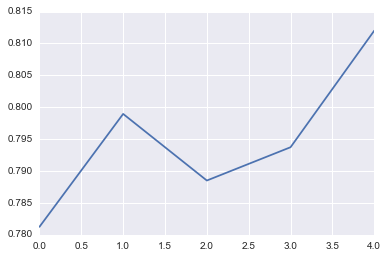

In [55]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

lsvc = CalibratedClassifierCV(SVC(C=0.9))
ts_lr = pyriemann.classification.TSclassifier(metric='riemann', clf=lsvc)
cross_val_4_clf(ts_lr, X_train_test, y_train_test)
valid_4_clf(ts_lr, X_train_test, y_train_test, X_valid, y_valid)

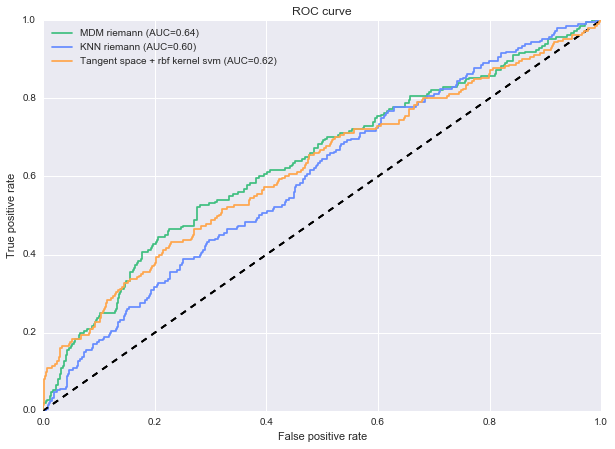

In [56]:
labels = ['MDM riemann', 'KNN riemann', 'Tangent space + rbf kernel svm']
clfs = [mdm, knn, ts_lr]
roc_auc(clfs, X_valid, y_valid, labels)

0.792271812446
0.78125
0.633641063282


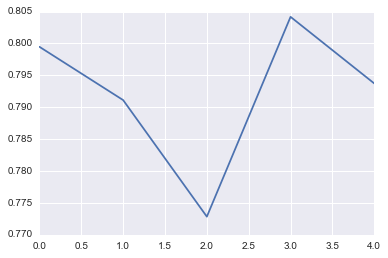

In [68]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

lsvc = GradientBoostingClassifier()
ts_lr = pyriemann.classification.TSclassifier(metric='riemann', clf=lsvc)
cross_val_4_clf(ts_lr, X_train_test, y_train_test)
valid_4_clf(ts_lr, X_train_test, y_train_test, X_valid, y_valid)